## Import

In [2]:
!pip install keras-cv
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout
from kerastuner.tuners import RandomSearch

<ipython-input-3-438ed8b334b7>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Load and Pre-process Data

In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.cifar10.load_data()
img_train.shape

170498071/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

In [ ]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualizing some of the images from the training dataset
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img_train[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[label_train[i][0]])

plt.show()

In [ ]:
# Converting the pixels data to float type and Standardizing (255 is the total number of pixels an image can have)
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

# One hot encoding the target class (labels)
num_classes = 10
label_train = tf.keras.utils.to_categorical(label_train, num_classes)
label_test = tf.keras.utils.to_categorical(label_test, num_classes)

## Base model

In [ ]:
def model_builder():
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

In [ ]:
model = model_builder()
history = model.fit(img_train, label_train, batch_size=64, epochs=30,
                    validation_data=(img_test, label_test))

Epoch 1/30
782/782 [==============================] - 8s 9ms/step - loss: 1.6210 - accuracy: 0.4080 - val_loss: 1.9682 - val_accuracy: 0.4083
Epoch 2/30
782/782 [==============================] - 7s 9ms/step - loss: 1.2120 - accuracy: 0.5647 - val_loss: 3.0011 - val_accuracy: 0.1816
Epoch 3/30
782/782 [==============================] - 7s 9ms/step - loss: 1.0938 - accuracy: 0.6107 - val_loss: 1.3347 - val_accuracy: 0.5480
Epoch 4/30
782/782 [==============================] - 7s 9ms/step - loss: 1.0244 - accuracy: 0.6399 - val_loss: 1.0764 - val_accuracy: 0.6154
Epoch 5/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9776 - accuracy: 0.6549 - val_loss: 1.1006 - val_accuracy: 0.6194
Epoch 6/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9351 - accuracy: 0.6707 - val_loss: 1.2633 - val_accuracy: 0.5546
Epoch 7/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9078 - accuracy: 0.6814 - val_loss: 0.8694 - val_accuracy: 0.6917
Epoch 

## Loading and Preprocessing

In [4]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

# load data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = normalize(X_train)
X_test = normalize(X_test)
X_train = X_train.reshape(-1,32, 32, 3)  # reshaping for convnet


y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

170498071/170498071 [==============================] - 2s 0us/step


## Keras Tuner

In [11]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('n_layers', 1, 4)):  # adding variation of layers.
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Choice('drop_out', values=[0.1, 0.2, 0.3])))
    model.add(Flatten())
    model.add(Dense(hp.Choice(f'n_nodes',
                              values=[128, 256, 512])))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation("softmax"))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # how many model variations to test?
    executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
    directory='deep_5',
    project_name='hw6_5')
# Number of epochs
NUM_EPOCH = 6

tuner.search(x=X_train,
             y=y_train,
             epochs=NUM_EPOCH,
             batch_size=32,
             validation_data=(X_test, y_test))

print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

model = tuner.get_best_models(num_models=1)[0]
print (model.summary())
# Evaluate the best model.
loss, accuracy = model.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

Trial 1 Complete [00h 03m 39s]
val_accuracy: 0.7016333341598511

Best val_accuracy So Far: 0.7016333341598511
Total elapsed time: 00h 03m 39s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 activation (Activation)     (None, 30, 30, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 13, 13, 64)        0         
                                              

None
{'n_layers': 3, 'drop_out': 0.1, 'n_nodes': 128, 'learning_rate': 0.001}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 activation (Activation)     (None, 30, 30, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 

## Train best model

In [13]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=8, batch_size=64)

Epoch 1/8
704/704 [==============================] - 6s 8ms/step - loss: 0.4011 - accuracy: 0.8605 - val_loss: 0.6481 - val_accuracy: 0.7852
Epoch 2/8
704/704 [==============================] - 5s 7ms/step - loss: 0.3717 - accuracy: 0.8706 - val_loss: 0.6323 - val_accuracy: 0.7895
Epoch 3/8
704/704 [==============================] - 6s 8ms/step - loss: 0.3474 - accuracy: 0.8767 - val_loss: 0.6120 - val_accuracy: 0.8024
Epoch 4/8
704/704 [==============================] - 5s 7ms/step - loss: 0.3327 - accuracy: 0.8816 - val_loss: 0.5975 - val_accuracy: 0.8104
Epoch 5/8
704/704 [==============================] - 6s 9ms/step - loss: 0.3200 - accuracy: 0.8852 - val_loss: 0.5906 - val_accuracy: 0.8180
Epoch 6/8
704/704 [==============================] - 7s 10ms/step - loss: 0.2983 - accuracy: 0.8916 - val_loss: 0.5878 - val_accuracy: 0.8250
Epoch 7/8
704/704 [==============================] - 5s 8ms/step - loss: 0.2751 - accuracy: 0.9015 - val_loss: 0.6403 - val_accuracy: 0.8132
Epoch 8/8
70

## Evaluate best model

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=1)
y_test_index = y_test.argmax(axis=1)
print(f"f1 score is : {f1_score(y_test_index, y_predicted, average='macro')}")
print(f"precision score is : {precision_score(y_test_index, y_predicted, average='macro')}")
print(f"recall score is :  {recall_score(y_test_index, y_predicted, average='macro')}")

313/313 [==============================] - 1s 2ms/step
f1 score is : 0.716950995882926
precision score is : 0.718713640713901
recall score is :  0.7171


## Analyse with Confusion Matrix

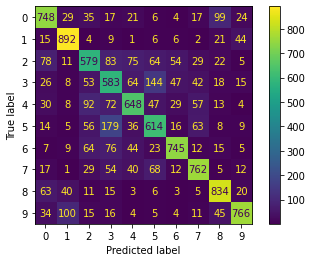

In [38]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_index, y_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.arange(10))

cm_display.plot()
plt.show()